# Tutorial 6b: A case study in FRAP

*This tutorial was generated from an IPython notebook.  You can download the notebook [here](t6b_frap.ipynb).*

With our new image processing skills, we can start to work on more complicated images.  For this tutorial, we will analyze a FRAP experiment and then perform parameter estimation to determine a diffusion coefficient and a binding rate for two molecules.  We will be taking a simplified approach, but there is more sophisticated analysis we can do to get better estimates for the phenomenological coefficients.  I invite you to read [the paper](../protected/papers/goehring_2010.pdf) by Goehring and coworkers that discusses this analysis.

Before we begin, we import our favorite modules, as always.

In [2]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

# This is a core Python module for communicating with the operating system
import os

import numpy as np
import scipy.special
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage.io

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline

## The data set

The data set comes from Nate Goehring.  The images are taken of a *C. elegans* one-cell embryo expressing a GFP fusion to the PH domain of Protein Lipase C delta 1 (PH-PLCd1).  This domain binds PIP2, a lipid enriched in the plasma membrane.  By using FRAP, we can investigate the dynamics of diffusion of the PH-PLCd1/PIP2 complex on the cell membrane, as well as the binding/unbinding dynamics of PH-PLCd1.

So, is $c$ is the concentration of the PH-PLDd1/PIP2 complex on the membrane and $c_\mathrm{cyto}$ is the concentration of PH-PLCd1 in the cytoplasm (assumed to be spatially uniform since diffusion in the cytoplasm is very fast), the dynamics are described by a reaction-diffusion equation.

\begin{align}
\frac{\partial c}{\partial t} = D\left(\frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}\right) + k_\mathrm{on} c_\mathrm{cyto} - k_\mathrm{off} c.
\end{align}

Here, $k_\mathrm{on}$ and $k_\mathrm{off}$ are the phenomenological rate constants for binding and unbinding to PIP2 on the membrane, and $D$ is the diffusion coefficient for the PH-PLCd1/PIP2 complex on the membrane.

In [their paper](../protected/papers/goehring_2010.pdf), the authors discuss techniques for analyzing the data taking into account the fluorescence recovery of the bleached region in time and space.  For simplicity here, we will only consider recovery of the normalized mean fluorescence.  If $I(t)$ is the mean fluorescence of the bleached region and $I_0$ is the mean fluorescence of the bleached region immediately before photobleaching, we have, as derived in the paper,

\begin{align}
I_\mathrm{norm}(t) \equiv \frac{I(t)}{I_0} &= 
1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t),\\[1mm]
\text{where } \psi_i(t) &= \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right),
\end{align}

where $d_x$ and $d_y$ are the extent of the photobleached box in the $x$- and $y$-directions, $f_b$ is the fraction of fluorophores that were bleached, and $\mathrm{erf}(x)$ is the [error function](http://en.wikipedia.org/wiki/Error_function).

We measure $I(t)$, $I_0$, $d_x$, and $d_y$.  We can also measure $f_b$ as

\begin{align}
f_b \approx 1 - \frac{I(0^+)}{I_0},
\end{align}

though we will consider this a parameter to estimate.

This leaves $D$ and $k_\mathrm{off}$ as the remaining free parameters to estimate by regression.

## Loading a TIFF stack

The FRAP data come in a **TIFF stack**, which is a single TIFF file containing multiple frames.  I have written a utility to help you load these type of files into an `XYTStack`.  We also know that the interpixel spacing is 0.138 µm and that the images are taken every 0.188 seconds.  We can pass these parameters in as keyword arguments when instantiating the `XYTStack`.  Note that the images in the TIFF stack were acquired with a 12-bit detector, so the maximum pixel value is 4095.

In [3]:
fname = '../data/t6_data/goehring_frap_data/PH_138_A.tif'
frap_xyt = jb.XYTStack(fname, physical_size_x=0.138, physical_size_y=0.138,
                       dt=0.188, one_channel=True, conserve_memory=False,
                       max_pixel=4095)

## Determining the bleach area

There are automated ways for determining the bleach area, and we would use that for high-throughput experiments, but we will use the ROI methods we learned in the first part of this tutorial.  According to the README file supplied by Nate Goehring, the last frame before photobleaching has index 19, and the first photobleached frame is frame 20.  We will therefore use frame 20 to deter the bleach area.

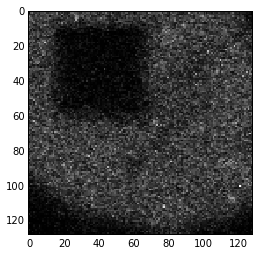

In [5]:
# First bleached frame
bleach_frame = 20

# Display image
skimage.io.imshow(skimage.exposure.rescale_intensity(frap_xyt.im(bleach_frame)))

# Get vertices for ROI (commented out for iPython notebook)
# verts = plt.ginput(100)
verts = [(15.166666666666679, 9.8333333333333428),
         (15.166666666666679, 60.5),
         (67.5, 62.166666666666671),
         (68.166666666666686, 9.8333333333333428)]

# Get the roi
frap_xyt.roi = [jb.verts_to_roi(verts, frap_xyt.size_x, frap_xyt.size_y)]

Let's see how we did the the ROI.

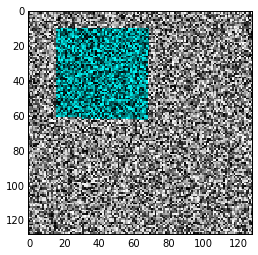

In [7]:
# Make RGB image
im = np.dstack(3 * [frap_xyt.im(bleach_frame)])
im[frap_xyt.roi[0][0], 0] = frap_xyt.max_pixel

# Show image
skimage.io.imshow(skimage.exposure.rescale_intensity(im))

## Computing average intensities

We'll first compute the average intensity before photobleaching.  This is done by averaging the average intensity of the first 20 frames.  Note that as we process these images, which have pixels with integer values, **it is imperative that we are using the Python 3 division operator.**

In [8]:
# Compute I_0
I_0 = 0.0
I_pre = np.empty(bleach_frame)
for i in range(bleach_frame):
    I_pre[i] = frap_xyt.im(i, roi=0)[frap_xyt.roi[0][2]].mean()
I_0 = I_pre.sum() / bleach_frame

# Reset time to that time = 0 is on bleach frame
t_pre = frap_xyt.t[:bleach_frame] - frap_xyt.t[bleach_frame]
t = frap_xyt.t[bleach_frame:] - frap_xyt.t[bleach_frame]

# Compute average I over time
I_mean = np.empty(frap_xyt.size_t - bleach_frame)
for i in range(bleach_frame, frap_xyt.size_t):
    I_mean[i-bleach_frame] = frap_xyt.im(i, roi=0)[frap_xyt.roi[0][2]].mean()

# Compute normalized intensity
I_norm = I_mean / I_0
I_pre_norm = I_pre / I_0

We can now plot the normalized intensity.

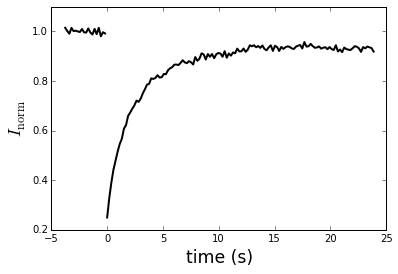

In [9]:
# Plot normalized intensity
plt.plot(t_pre, I_pre_norm, 'k-')
plt.plot(t, I_norm, 'k-')
plt.xlabel('time (s)')
plt.ylabel(r'$I_\mathrm{norm}$')

## Parameter estimation

We see that the normalized fluorescent recovery does not go all the way to unity.  This is because the FRAP area is a significant portion of the membrane, and we have depleted fluorescent molecules.  We should thus adjust our equation to be

\begin{align}
I_\mathrm{norm}(t) \equiv \frac{I(t)}{I_0} &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),
\end{align}

where $f_f$ is the fraction of fluorescent species left. We assume a Gaussian likelihood (neglecting to put our usual "$I$" in the definitions of our probabilities so as not to confuse it with intensity).

\begin{align}
P(D~|~f_b, f_f, D, k_\mathrm{off}, \sigma) &= \prod_{i\in D}\frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left\{-\frac{\left(I_\mathrm{norm,i} - I_\mathrm{norm}(t_i;f_b, f_f, D, k_\mathrm{off})\right)^2}{2\sigma^2}\right\}.
\end{align}

We assume uniform priors on all parameters except $\sigma$.  Our marginalized log posterior is then given by the log of the Student-t distribution, as we have derived before.
\begin{align}
\ln P(f_b, f_f, D, k_\mathrm{off}~|~D) = \text{constant} - \frac{n}{2}\ln\left[\sum_{i\in D}\left(I_\mathrm{norm,i} - I_\mathrm{norm}(t_i;f_b, f_f, D, k_\mathrm{off})\right)^2\right].
\end{align}

In order to do our regression, we need to measure $d_x$ and $d_y$.  We can get it from the vertices of our ROI.

In [10]:
# Compute FRAP window measurements (in units microns
d_y = np.sqrt((verts[1][1] - verts[0][1])**2 
              + (verts[1][0] - verts[0][0])**2) * frap_xyt.physical_size_x
d_x = np.sqrt((verts[2][1] - verts[1][1])**2 
              + (verts[2][0] - verts[1][0])**2) * frap_xyt.physical_size_x

We are now ready to do our regression.  We will use `scipy.optimize.leastsq` to do it.

In [11]:
# Define log posterior
def log_posterior(p, I_norm, t, d_x, d_y):
    """
    Return log of the posterior.
    """
    return -len(I_norm) / 2.0 * np.log(
            ((I_norm - norm_fluor_recov(p, t, d_x, d_y))**2).sum())

# Define fit function
def norm_fluor_recov(p, t, d_x, d_y):
    """
    Return normalized fluorescence as function of time.
    """
    # Unpack parameters
    f_b, f_f, D, k_off = p

    # Function to compute psi
    def psi(t, D, d_i):
        return d_i / 2.0 * scipy.special.erf(d_i / np.sqrt(4.0 * D * t)) \
                     - np.sqrt(D * t / np.pi) \
                                * (1.0- np.exp(-d_i**2 / (4.0 * D * t)))
    psi_x = psi(t, D, d_x)
    psi_y = psi(t, D, d_y)
    return f_f * (1.0 - f_b * 4.0 * np.exp(-k_off * t) / d_x / d_y 
                            * psi_x * psi_y)

# Define residual
def resid(p, I_norm, t, d_x, dy):
    return I_norm - norm_fluor_recov(p,t, d_x, d_y)

# Perform the curve fit
p0 = np.array([0.9, 0.9, 10.0, 0.1])
popt, junk_output = scipy.optimize.leastsq(resid, p0, 
                                           args=(I_norm, t, d_x, d_y))

# Compute the covariance
hes = jb.hess_nd(log_posterior, popt, args=(I_norm, t, d_x, d_y))
cov = -np.linalg.inv(hes)

# Report results
formats = tuple(popt) + tuple(np.sqrt(np.diag(cov)))
print("""
f_f = {0:.3f} +- {4:.3f}
f_b = {1:.3f} +- {5:.3f}
D = {2:.3f} +- {6:.3f} µm^2/s
k_off = {3:.3f} +- {7:.3f} (1/s)
""".format(*formats))



f_f = 0.752 +- 0.009
f_b = 0.936 +- 0.002
D = 0.887 +- 0.151 µm^2/s
k_off = 0.223 +- 0.017 (1/s)



/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/Justin/anaconda/lib/python3.4/site-pa

Let's look at the results.

/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide


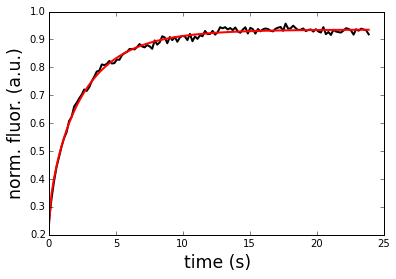

In [12]:
# Plot recovery trace
plt.plot(t, I_norm, 'k-')
plt.plot(t, norm_fluor_recov(popt, t, d_x, d_y), 'r-')
plt.xlabel('time (s)')
plt.ylabel('norm. fluor. (a.u.)')

Let's try the same calculation with only diffusive recovery.

/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/pytho


f_f = 0.834 +- 0.012
f_b = 0.999 +- 0.003
D = 2.891 +- 0.116 µm^2/s



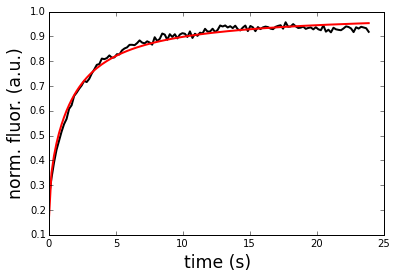

In [13]:
# Define log posterior
def log_posterior_diff_only(p, I_norm, t, d_x, d_y):
    """
    Return log of the posterior.
    """
    return -len(I_norm) / 2.0 * np.log(
            ((I_norm - norm_fluor_recov_diff_only(p, t, d_x, d_y))**2).sum())

# Define fit function
def norm_fluor_recov_diff_only(p, t, d_x, d_y):
    """
    Return normalized fluorescence as function of time.
    """
    # Unpack parameters
    new_p = np.concatenate((p, (0.0,)))
    return norm_fluor_recov(new_p, t, d_x, d_y)

# Define residual
def resid_diff_only(p, I_norm, t, d_x, dy):
    return I_norm - norm_fluor_recov_diff_only(p, t, d_x, d_y)

# Perform the curve fit
p0 = np.array([0.9, 0.9, 10.0])
popt_diff_only, junk_output = scipy.optimize.leastsq(resid_diff_only, p0, 
                                           args=(I_norm, t, d_x, d_y))

# Compute the covariance
hes = jb.hess_nd(log_posterior_diff_only, popt_diff_only,
                 args=(I_norm, t, d_x, d_y))
cov_diff_only = -np.linalg.inv(hes)

# Report results
formats = tuple(popt_diff_only) + tuple(np.sqrt(np.diag(cov_diff_only)))
print("""
f_f = {0:.3f} +- {3:.3f}
f_b = {1:.3f} +- {4:.3f}
D = {2:.3f} +- {5:.3f} µm^2/s
""".format(*formats))

# Plot recovery trace
plt.plot(t, I_norm, 'k-')
plt.plot(t, norm_fluor_recov_diff_only(popt_diff_only, t, d_x, d_y), 'r-')
plt.xlabel('time (s)')
plt.ylabel('norm. fluor. (a.u.)')

And now with only exhange, no diffusion.

/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/Justin/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide



f_f = 0.668 +- 0.008
f_b = 0.930 +- 0.002
k_off = 0.389 +- 0.008 (1/s)



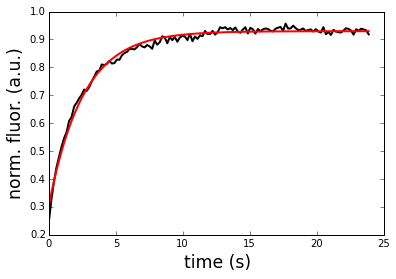

In [14]:
# Define log posterior
def log_posterior_no_diff(p, I_norm, t, d_x, d_y):
    """
    Return log of the posterior.
    """
    return -len(I_norm) / 2.0 * np.log(
            ((I_norm - norm_fluor_recov_no_diff(p, t, d_x, d_y))**2).sum())

# Define fit function
def norm_fluor_recov_no_diff(p, t, d_x, d_y):
    """
    Return normalized fluorescence as function of time.
    """
    # Unpack parameters
    new_p = np.array([p[0], p[1], 0.0, p[2]])
    return norm_fluor_recov(new_p, t, d_x, d_y)

# Define residual
def resid_no_diff(p, I_norm, t, d_x, dy):
    return I_norm - norm_fluor_recov_no_diff(p, t, d_x, d_y)

# Perform the curve fit
p0 = np.array([0.9, 0.9, 0.1])
popt_no_diff, junk_output = scipy.optimize.leastsq(resid_no_diff, p0, 
                                           args=(I_norm, t, d_x, d_y))

# Compute the covariance
hes = jb.hess_nd(log_posterior_no_diff, popt_no_diff,
                 args=(I_norm, t, d_x, d_y))
cov_no_diff = -np.linalg.inv(hes)

# Report results
formats = tuple(popt_no_diff) + tuple(np.sqrt(np.diag(cov_no_diff)))
print("""
f_f = {0:.3f} +- {3:.3f}
f_b = {1:.3f} +- {4:.3f}
k_off = {2:.3f} +- {5:.3f} (1/s)
""".format(*formats))

# Plot recovery trace
plt.plot(t, I_norm, 'k-')
plt.plot(t, norm_fluor_recov_no_diff(popt_no_diff, t, d_x, d_y), 'r-')
plt.xlabel('time (s)')
plt.ylabel('norm. fluor. (a.u.)')

From eyeballing it, we can conclude that there is definitely exachange.  We would need to more carefully consider the spatial distribution over time and not just the mean intensity to ascertain the effects of diffusion.  We should do that first before doing model selection, and it considers all of the data, and not just the mean values for the bleach region.